<div style="color:white;background-color:#0c29d0;padding:3%;border-radius:150px 150px;font-size:2em;text-align:center"> <font color="White" size=+5 face="verdana"><div style="align:center: justify">Olist RFM Segmentation</font></div>

# Olá!

<center><img src = 'https://media.giphy.com/media/xT9IgG50Fb7Mi0prBC/giphy.gif'></center>

## Vamos começar !!!!

Neste notebook vou fazer uma Análise Exploratória dos Dados do site de e-commerce brasileiro Olist. A análise visa responder a algumas questões-chave de negócios e descobrir os dados em geral. Após a EDA, será feita uma análise de Recência, Frequência e Valor Monetário (RFM) para agrupar os clientes em segmentos de marketing predefinidos.

### CONTEXTO 

Este conjunto de dados é da Olist, o maior marketplace do Brasil. Esses dados foram coletados no período de 2016 a 2018. A Olist conecta pequenas empresas de todo o Brasil para entrar em sua rede com muita facilidade com apenas um contrato. Esses empreendedores podem vender seus produtos pela plataforma Olist e enviá-los diretamente aos seus clientes por meio de correios que já trabalharam com a Olist.

Depois que o cliente comprar o produto da Olist, o vendedor receberá uma notificação para atender imediatamente o pedido do cliente. Ao receber o produto, o cliente pode fornecer um índice de satisfação e comentários sobre os serviços prestados pelo vendedor através do e-mail enviado.

Os dados coletados estão contidos em 9 arquivos diferentes, portanto, eles precisam ser combinados para obter todos os dados com base nos parâmetros que desejamos. Abaixo está um esquema de conexão entre os dados a serem usados ​​como referência ao mesclar dados.

<div>
<center><img src="olist_dataset.png" width="800"/></center>
</div>

In [1]:
# IMPORTAR AS BIBLIOTECAS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)

In [2]:
# CARREGAR OS DADOS

olist_orders = pd.read_csv('olist_orders_dataset.csv')
olist_products = pd.read_csv('olist_products_dataset.csv')
olist_items = pd.read_csv('olist_order_items_dataset.csv')
olist_customers = pd.read_csv('olist_customers_dataset.csv')
olist_payments = pd.read_csv('olist_order_payments_dataset.csv')
olist_sellers = pd.read_csv('olist_sellers_dataset.csv')
olist_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
olist_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
olist_product_category_name = pd.read_csv('olist_product_category_name_translation.csv')

In [3]:
# TRATAMENTO DOS DADOS

olist_items.drop(['seller_id'], axis = 1, inplace = True)
olist_items.drop(['shipping_limit_date'], axis = 1, inplace = True)
olist_customers.drop(['customer_zip_code_prefix'], axis = 1, inplace = True)

olist_orders = olist_orders.loc[olist_orders['order_status'] == 'delivered']
olist_orders['order_purchase_timestamp'] = pd.to_datetime(olist_orders['order_purchase_timestamp'])

olist_orders['order_estimated_delivery_date'] = pd.to_datetime(olist_orders['order_estimated_delivery_date'])
olist_orders['order_delivered_customer_date'] = pd.to_datetime(olist_orders['order_delivered_customer_date'])

olist_orders['dif_previsao_entrega'] = ((olist_orders['order_estimated_delivery_date']) - (olist_orders['order_delivered_customer_date'])).dt.days
olist_orders['dif_previsao_entrega'].fillna(0, inplace = True)
olist_orders.dropna(inplace = True)
olist_orders['dif_previsao_entrega'] = olist_orders['dif_previsao_entrega'].astype('int64')

olist_products['product_category_name'].fillna('Não informado', inplace = True)

In [4]:
# NOVAS FEATURES

olist_orders['ano_compra'] = olist_orders['order_purchase_timestamp'].dt.year
olist_orders['mes_compra'] = olist_orders['order_purchase_timestamp'].dt.month
olist_orders['dia_compra'] = olist_orders['order_purchase_timestamp'].dt.day
olist_orders['dia_semana_compra'] = olist_orders['order_purchase_timestamp'].dt.weekday

olist_orders.drop(['order_approved_at'], axis = 1, inplace = True)
olist_orders.drop(['order_delivered_carrier_date'], axis = 1, inplace = True)
olist_orders.drop(['order_delivered_customer_date'], axis = 1, inplace = True)
olist_orders.drop(['order_estimated_delivery_date'], axis = 1, inplace = True)

olist_products.drop(['product_name_lenght'], axis = 1, inplace = True)
olist_products.drop(['product_photos_qty'], axis = 1, inplace = True)
olist_products.drop(['product_description_lenght'], axis = 1, inplace = True)
olist_products.drop(['product_weight_g'], axis = 1, inplace = True)
olist_products.drop(['product_length_cm'], axis = 1, inplace = True)
olist_products.drop(['product_height_cm'], axis = 1, inplace = True)
olist_products.drop(['product_width_cm'], axis = 1, inplace = True)

In [5]:
nome_dia = []
for i in olist_orders.dia_semana_compra:
    if i == 6:
        i = 'dom'
    elif i == 0:
        i = 'seg'
    elif i == 1:
        i = 'ter'
    elif i == 2:
        i = 'qua'
    elif i == 3:
        i = 'qui'
    elif i == 4:
        i = 'sex'
    else:
        i = 'sab'
    nome_dia.append(i)
olist_orders['dia_semana_compra'] = nome_dia

In [6]:
olist_reviews['review_comment_title'].fillna('Sem Titulo', inplace = True)
olist_reviews['review_comment_message'].fillna('Sem Mensagem', inplace = True)
olist_reviews.drop(['review_id'], axis = 1, inplace = True)
olist_reviews.drop(['review_comment_title'], axis = 1, inplace = True)
olist_reviews.drop(['review_comment_message'], axis = 1, inplace = True)
olist_reviews.drop(['review_creation_date'], axis = 1, inplace = True)
olist_reviews.drop(['review_answer_timestamp'], axis = 1, inplace = True)
olist_reviews = olist_reviews.drop_duplicates(subset = 'order_id', keep = 'last')

In [7]:
df = pd.merge(olist_orders, olist_items, on = 'order_id', how = 'left')
df = pd.merge(df, olist_products, on = 'product_id', how = 'left')
df = pd.merge(df, olist_customers, on = 'customer_id', how = 'left')
df = pd.merge(df, olist_reviews, on = 'order_id', how = 'left')
df = pd.merge(df, olist_payments, on = 'order_id',  how = 'left')

In [8]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,dif_previsao_entrega,ano_compra,mes_compra,dia_compra,dia_semana_compra,order_item_id,product_id,price,freight_value,product_category_name,customer_unique_id,customer_city,customer_state,review_score,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7,2017,10,2,seg,1,87285b34884572647811a353c7ac498a,29.99,8.72,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,4.0,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7,2017,10,2,seg,1,87285b34884572647811a353c7ac498a,29.99,8.72,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,4.0,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7,2017,10,2,seg,1,87285b34884572647811a353c7ac498a,29.99,8.72,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,4.0,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,5,2018,7,24,ter,1,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,perfumaria,af07308b275d755c9edb36a90c618231,barreiras,BA,4.0,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,17,2018,8,8,qua,1,aa4383b373c6aca5d8797843e5594415,159.90,19.22,automotivo,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,5.0,1.0,credit_card,3.0,179.12


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115014 entries, 0 to 115013
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  115014 non-null  object        
 1   customer_id               115014 non-null  object        
 2   order_status              115014 non-null  object        
 3   order_purchase_timestamp  115014 non-null  datetime64[ns]
 4   dif_previsao_entrega      115014 non-null  int64         
 5   ano_compra                115014 non-null  int64         
 6   mes_compra                115014 non-null  int64         
 7   dia_compra                115014 non-null  int64         
 8   dia_semana_compra         115014 non-null  object        
 9   order_item_id             115014 non-null  int64         
 10  product_id                115014 non-null  object        
 11  price                     115014 non-null  float64       
 12  fr

In [10]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,dif_previsao_entrega,ano_compra,mes_compra,dia_compra,dia_semana_compra,order_item_id,product_id,price,freight_value,product_category_name,customer_unique_id,customer_city,customer_state,review_score,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7,2017,10,2,seg,1,87285b34884572647811a353c7ac498a,29.99,8.72,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,4.0,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7,2017,10,2,seg,1,87285b34884572647811a353c7ac498a,29.99,8.72,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,4.0,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7,2017,10,2,seg,1,87285b34884572647811a353c7ac498a,29.99,8.72,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,4.0,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,5,2018,7,24,ter,1,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,perfumaria,af07308b275d755c9edb36a90c618231,barreiras,BA,4.0,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,17,2018,8,8,qua,1,aa4383b373c6aca5d8797843e5594415,159.90,19.22,automotivo,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,5.0,1.0,credit_card,3.0,179.12


In [11]:
sudeste = ['SP', 'RJ', 'ES', 'MG']
nordeste = ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
norte = ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
centro_oeste = ['MT', 'GO', 'MS' ,'DF']
sul = ['SC', 'RS', 'PR']

df.loc[df['customer_state'].isin(sudeste), 'regiao_cliente'] = 'Sudeste'
df.loc[df['customer_state'].isin(nordeste), 'regiao_cliente'] = 'Nordeste'
df.loc[df['customer_state'].isin(norte), 'regiao_cliente'] = 'Norte'
df.loc[df['customer_state'].isin(centro_oeste), 'regiao_cliente'] = 'Centro-Oeste'
df.loc[df['customer_state'].isin(sul), 'regiao_cliente'] = 'Sul'

In [12]:
df['data_compra'] = df['order_purchase_timestamp'].dt.date
df['hora_compra'] = df['order_purchase_timestamp'].dt.round('360min')
df['hora_compra'] = df['hora_compra'].dt.time

df['mes_e_ano_compra'] = df['order_purchase_timestamp'].dt.strftime('%m-%Y')

df.drop(['order_purchase_timestamp'], axis = 1, inplace = True)

In [13]:
df.head()

,order_id,customer_id,order_status,dif_previsao_entrega,ano_compra,mes_compra,dia_compra,dia_semana_compra,order_item_id,product_id,price,freight_value,product_category_name,customer_unique_id,customer_city,customer_state,review_score,payment_sequential,payment_type,payment_installments,payment_value,regiao_cliente,data_compra,hora_compra,mes_e_ano_compra
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,7,2017,10,2,seg,1,87285b34884572647811a353c7ac498a,29.99,8.72,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,4.0,1.0,credit_card,1.0,18.12,Sudeste,2017-10-02,12:00:00,10-2017
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,7,2017,10,2,seg,1,87285b34884572647811a353c7ac498a,29.99,8.72,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,4.0,3.0,voucher,1.0,2.00,Sudeste,2017-10-02,12:00:00,10-2017
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,7,2017,10,2,seg,1,87285b34884572647811a353c7ac498a,29.99,8.72,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,4.0,2.0,voucher,1.0,18.59,Sudeste,2017-10-02,12:00:00,10-2017
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,5,2018,7,24,ter,1,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,perfumaria,af07308b275d755c9edb36a90c618231,barreiras,BA,4.0,1.0,boleto,1.0,141.46,Nordeste,2018-07-24,18:00:00,07-2018
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,17,2018,8,8,qua,1,aa4383b373c6aca5d8797843e5594415,159.90,19.22,automotivo,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,5.0,1.0,credit_card,3.0,179.12,Centro-Oeste,2018-08-08,06:00:00,08-2018


In [14]:
df = df[['order_id','order_status','dia_compra','mes_compra','ano_compra','dia_semana_compra','mes_e_ano_compra',
         'data_compra','hora_compra','payment_type','payment_sequential','payment_installments','payment_value',
         'dif_previsao_entrega','product_id','product_category_name','order_item_id','price','freight_value',
         'review_score','customer_id','customer_unique_id','customer_city','customer_state','regiao_cliente']]
df.head()

,order_id,order_status,dia_compra,mes_compra,ano_compra,dia_semana_compra,mes_e_ano_compra,data_compra,hora_compra,payment_type,payment_sequential,payment_installments,payment_value,dif_previsao_entrega,product_id,product_category_name,order_item_id,price,freight_value,review_score,customer_id,customer_unique_id,customer_city,customer_state,regiao_cliente
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2,10,2017,seg,10-2017,2017-10-02,12:00:00,credit_card,1.0,1.0,18.12,7,87285b34884572647811a353c7ac498a,utilidades_domesticas,1,29.99,8.72,4.0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,Sudeste
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2,10,2017,seg,10-2017,2017-10-02,12:00:00,voucher,3.0,1.0,2.00,7,87285b34884572647811a353c7ac498a,utilidades_domesticas,1,29.99,8.72,4.0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,Sudeste
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2,10,2017,seg,10-2017,2017-10-02,12:00:00,voucher,2.0,1.0,18.59,7,87285b34884572647811a353c7ac498a,utilidades_domesticas,1,29.99,8.72,4.0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,Sudeste
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,24,7,2018,ter,07-2018,2018-07-24,18:00:00,boleto,1.0,1.0,141.46,5,595fac2a385ac33a80bd5114aec74eb8,perfumaria,1,118.70,22.76,4.0,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,barreiras,BA,Nordeste
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,8,8,2018,qua,08-2018,2018-08-08,06:00:00,credit_card,1.0,3.0,179.12,17,aa4383b373c6aca5d8797843e5594415,automotivo,1,159.90,19.22,5.0,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,Centro-Oeste


In [15]:
df.rename(columns = {'order_id':'id_pedido'}, inplace = True)
df.rename(columns = {'order_status':'status_pedido'}, inplace = True)
df.rename(columns = {'product_id':'id_produto'},inplace = True)
df.rename(columns = {'product_category_name':'categoria'}, inplace = True)
df.rename(columns = {'order_item_id':'id_item_pedido'}, inplace = True)
df.rename(columns = {'payment_type':'tipo_pagamento'}, inplace = True)
df.rename(columns = {'payment_sequential':'ordem_pagamento'}, inplace = True) 
df.rename(columns = {'payment_installments':'qtd_parcelas'}, inplace = True)
df.rename(columns = {'payment_value':'total_pago'}, inplace = True) 
df.rename(columns = {'price':'preco'}, inplace = True) 
df.rename(columns = {'freight_value':'valor_frete'}, inplace = True)
df.rename(columns = {'review_score':'nota'}, inplace = True) 
df.rename(columns = {'customer_id':'id_cliente'}, inplace = True)
df.rename(columns = {'customer_city':'cidade_cliente'}, inplace = True)
df.rename(columns = {'customer_state':'estado_cliente'}, inplace = True)      

In [16]:
df.head()

,id_pedido,status_pedido,dia_compra,mes_compra,ano_compra,dia_semana_compra,mes_e_ano_compra,data_compra,hora_compra,tipo_pagamento,ordem_pagamento,qtd_parcelas,total_pago,dif_previsao_entrega,id_produto,categoria,id_item_pedido,preco,valor_frete,nota,id_cliente,customer_unique_id,cidade_cliente,estado_cliente,regiao_cliente
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2,10,2017,seg,10-2017,2017-10-02,12:00:00,credit_card,1.0,1.0,18.12,7,87285b34884572647811a353c7ac498a,utilidades_domesticas,1,29.99,8.72,4.0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,Sudeste
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2,10,2017,seg,10-2017,2017-10-02,12:00:00,voucher,3.0,1.0,2.00,7,87285b34884572647811a353c7ac498a,utilidades_domesticas,1,29.99,8.72,4.0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,Sudeste
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2,10,2017,seg,10-2017,2017-10-02,12:00:00,voucher,2.0,1.0,18.59,7,87285b34884572647811a353c7ac498a,utilidades_domesticas,1,29.99,8.72,4.0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,Sudeste
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,24,7,2018,ter,07-2018,2018-07-24,18:00:00,boleto,1.0,1.0,141.46,5,595fac2a385ac33a80bd5114aec74eb8,perfumaria,1,118.70,22.76,4.0,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,barreiras,BA,Nordeste
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,8,8,2018,qua,08-2018,2018-08-08,06:00:00,credit_card,1.0,3.0,179.12,17,aa4383b373c6aca5d8797843e5594415,automotivo,1,159.90,19.22,5.0,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,Centro-Oeste


In [17]:
# Exploration Data Analysis

filtro = df['mes_compra'].isin([1,2,3,4,5,6,7,8])
df_aux = df[filtro]
df_aux

,id_pedido,status_pedido,dia_compra,mes_compra,ano_compra,dia_semana_compra,mes_e_ano_compra,data_compra,hora_compra,tipo_pagamento,ordem_pagamento,qtd_parcelas,total_pago,dif_previsao_entrega,id_produto,categoria,id_item_pedido,preco,valor_frete,nota,id_cliente,customer_unique_id,cidade_cliente,estado_cliente,regiao_cliente
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,24,7,2018,ter,07-2018,2018-07-24,18:00:00,boleto,1.0,1.0,141.46,5,595fac2a385ac33a80bd5114aec74eb8,perfumaria,1,118.70,22.76,4.0,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,barreiras,BA,Nordeste
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,8,8,2018,qua,08-2018,2018-08-08,06:00:00,credit_card,1.0,3.0,179.12,17,aa4383b373c6aca5d8797843e5594415,automotivo,1,159.90,19.22,5.0,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,Centro-Oeste
6,ad21c59c0840e6cb83a9ceb5573f8159,delivered,13,2,2018,ter,02-2018,2018-02-13,00:00:00,credit_card,1.0,1.0,28.62,9,65266b2da20d04dbe00c5c2d3bb7859e,papelaria,1,19.90,8.72,5.0,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,santo andre,SP,Sudeste
7,a4591c265e18cb1dcee52889e2d8acc3,delivered,9,7,2017,dom,07-2017,2017-07-09,00:00:00,credit_card,1.0,6.0,175.26,5,060cb19345d90064d1015407193c233d,automotivo,1,147.90,27.36,4.0,503740e9ca751ccdda7ba28e9ab8f608,80bb27c7c16e8f973207a5086ab329e2,congonhinhas,PR,Sul
8,6514b8ad8028c9f2cc2374ded245783f,delivered,16,5,2017,ter,05-2017,2017-05-16,12:00:00,credit_card,1.0,3.0,75.16,11,4520766ec412348b8d4caa5e8a18c464,automotivo,1,59.99,15.17,5.0,9bdf08b4b3b52b5526ff42d37d47f222,932afa1e708222e5821dac9cd5db4cae,nilopolis,RJ,Sudeste
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115009,63943bddc261676b46f01ca7ac2f7bd8,delivered,6,2,2018,ter,02-2018,2018-02-06,12:00:00,credit_card,1.0,3.0,195.00,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,bebes,1,174.90,20.10,4.0,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660,praia grande,SP,Sudeste
115010,83c1379a015df1e13d02aae0204711ab,delivered,27,8,2017,dom,08-2017,2017-08-27,12:00:00,credit_card,1.0,5.0,271.01,5,b80910977a37536adeddd63663f916ad,eletrodomesticos_2,1,205.99,65.02,5.0,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30,nova vicosa,BA,Nordeste
115011,11c177c8e97725db2631073c19f07b62,delivered,8,1,2018,seg,01-2018,2018-01-08,00:00:00,credit_card,1.0,4.0,441.16,20,d1c427060a0f73f6b889a5c7c61f2ac4,informatica_acessorios,1,179.99,40.59,2.0,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,japuiba,RJ,Sudeste
115012,11c177c8e97725db2631073c19f07b62,delivered,8,1,2018,seg,01-2018,2018-01-08,00:00:00,credit_card,1.0,4.0,441.16,20,d1c427060a0f73f6b889a5c7c61f2ac4,informatica_acessorios,2,179.99,40.59,2.0,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,japuiba,RJ,Sudeste


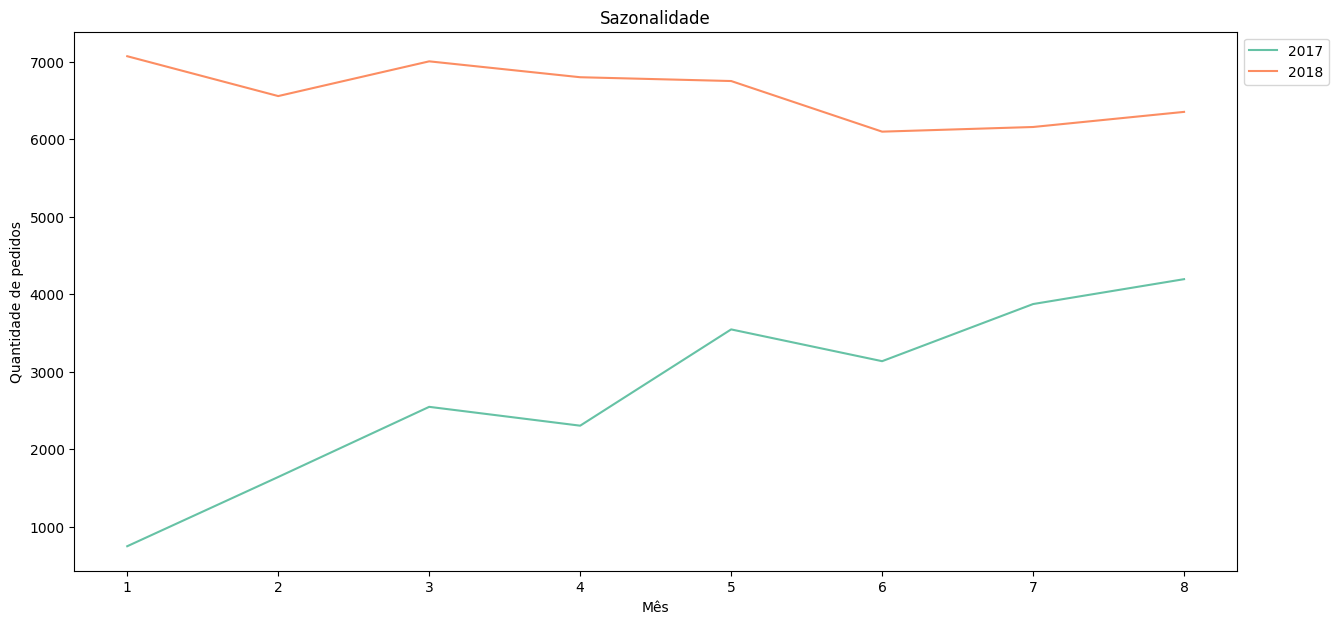

In [18]:
# Histórico de compras

plt.figure(figsize = (15,7))
sazonalidade = df_aux.groupby(['mes_compra', 'ano_compra'])['id_pedido'].nunique().sort_values(ascending=True).reset_index()

sns.lineplot(data = sazonalidade,
             x = 'mes_compra',
             y = 'id_pedido',
             hue = 'ano_compra',
             legend = 'full',
             palette = 'Set2')
plt.title('Sazonalidade')
plt.ylabel('Quantidade de pedidos')
plt.xlabel('Mês')

plt.legend(bbox_to_anchor = (1.0, 1), loc = 2);

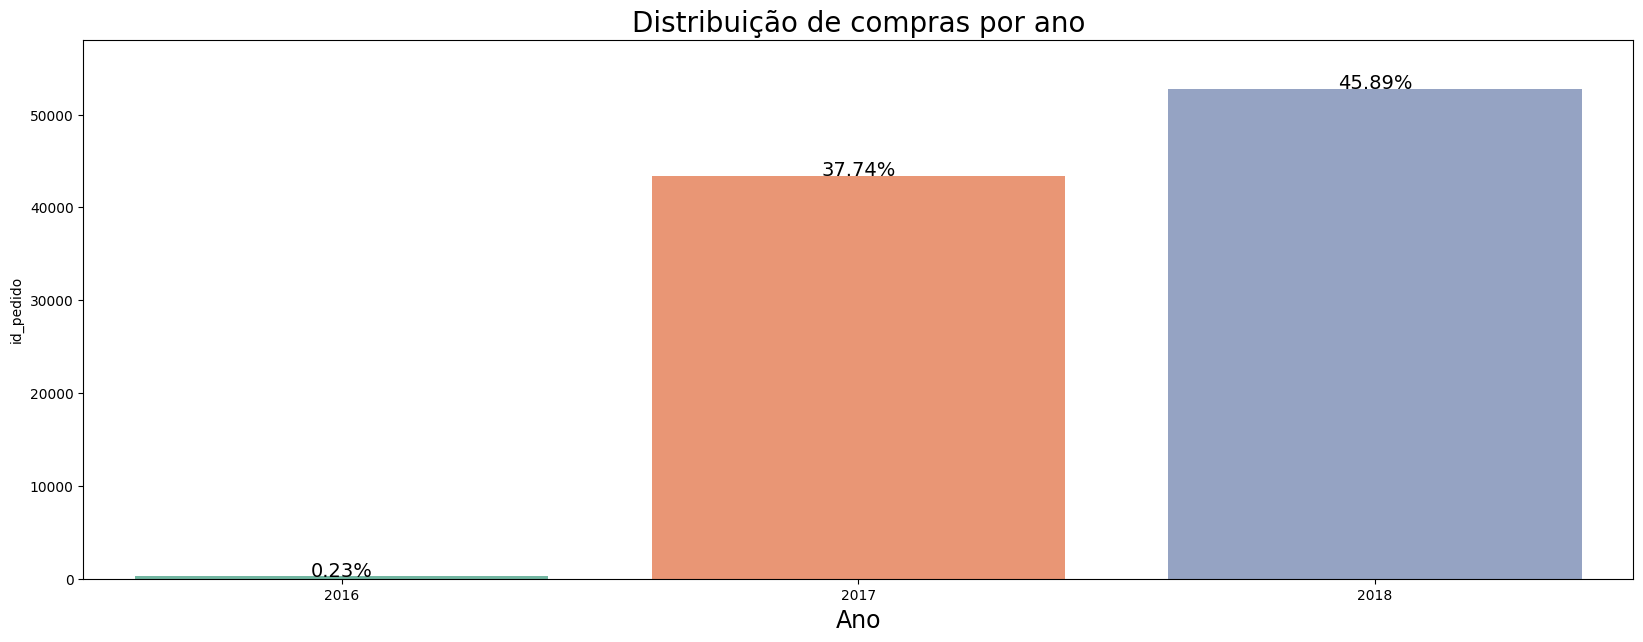

In [19]:
# Histórico de receitas

plt.figure(figsize = (20,7))
plt.subplot(111)
sazonalidade_ano = df.groupby(['ano_compra'])['id_pedido'].nunique().sort_values(ascending=True).reset_index()
total = len(df)
g = sns.barplot(x = 'ano_compra', y = 'id_pedido', data = sazonalidade_ano, palette ='Set2')
g.set_title('Distribuição de compras por ano', fontsize = 20)
g.set_xlabel('Ano', fontsize = 17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.2f}%'.format(height / total * 100),
                                           ha = 'center', fontsize = 14)
    g.set_ylim(0, max(sizes) * 1.1)


Text(0.5, 1.0, 'Top 10 categorias com mais pedidos')

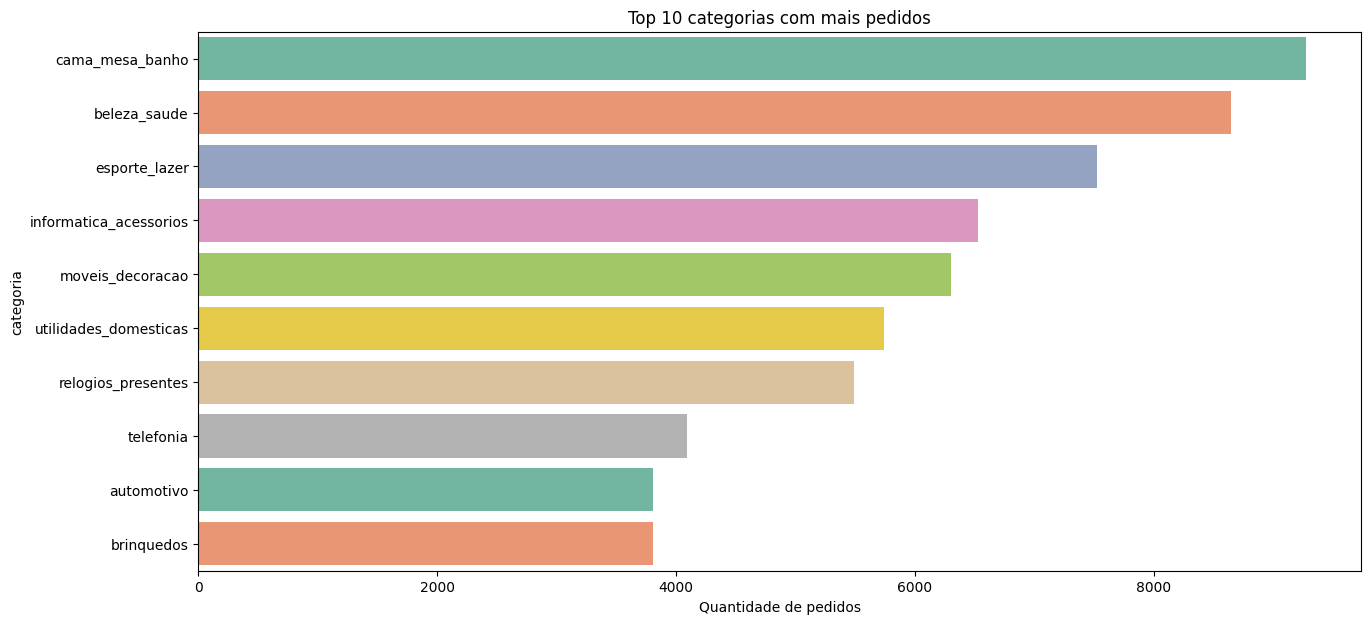

In [20]:
# Comportamento de compra

produtos_mais_vendidos = df.groupby('categoria')['id_pedido'].nunique().sort_values(ascending = False).head(10)
produtos_mais_vendidos

plt.figure(figsize = (15,7))
sns.barplot(y = produtos_mais_vendidos.index, x = produtos_mais_vendidos, palette = 'Set2')
plt.xlabel('Quantidade de pedidos')
plt.title('Top 10 categorias com mais pedidos')

Text(0, 0.5, 'Quantidade de pedidos')

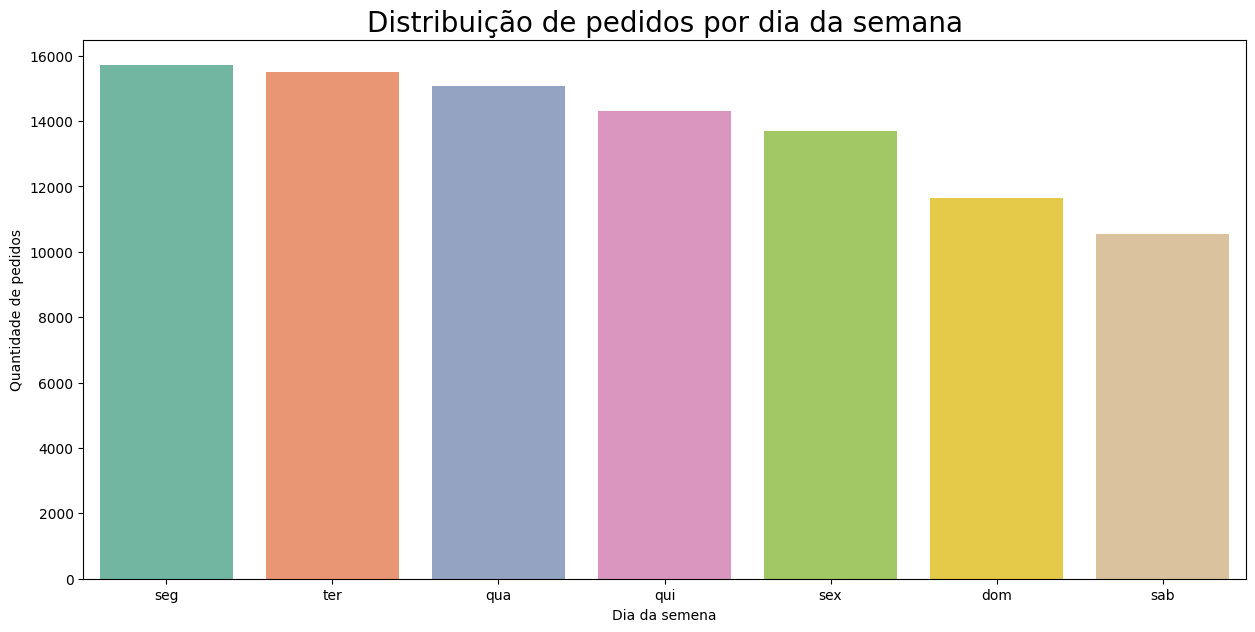

In [21]:
# Distribuição de pedidos por dia da semana

plt.figure(figsize = (15,7))
sazonalidade_semana = df.groupby(['dia_semana_compra'])['id_pedido'].nunique().sort_values(ascending = False).reset_index()
sns.barplot(x = 'dia_semana_compra', y = 'id_pedido', data = sazonalidade_semana, palette = 'Set2')
plt.title('Distribuição de pedidos por dia da semana', fontsize = 20)
plt.xlabel('Dia da semena')
plt.ylabel('Quantidade de pedidos')

Text(0.5, 0, 'Quantidade de pedidos')

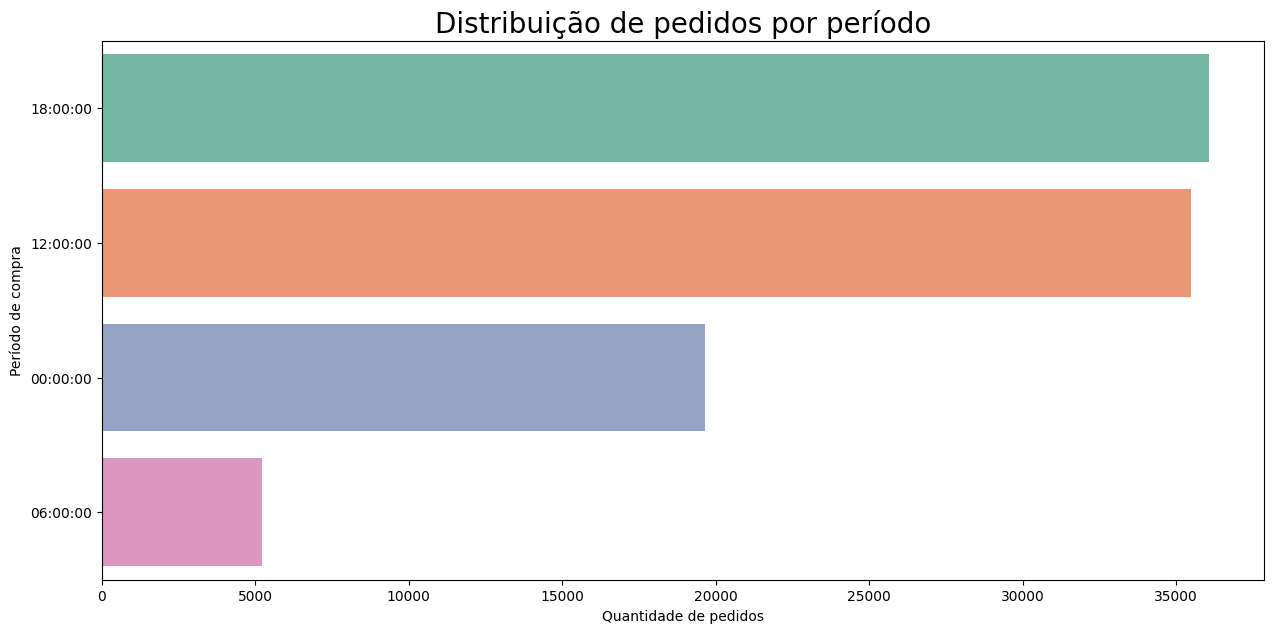

In [22]:
# Distribuição de pedidos por hora do dia

plt.figure(figsize = (15,7))
sazonalidade_hora = df.groupby(['hora_compra'])['id_pedido'].nunique().sort_values(ascending = False).reset_index()
sns.barplot(y = 'hora_compra', x = 'id_pedido', data = sazonalidade_hora, palette = 'Set2')
plt.title('Distribuição de pedidos por período', fontsize = 20)
plt.ylabel('Período de compra')
plt.xlabel('Quantidade de pedidos')

In [23]:
# Distribuição dos tipos de pagamento por mês

total_influencia_parcelas = df.groupby(['id_cliente', 
                                       'tipo_pagamento', 
                                       'mes_compra', 
                                       'qtd_parcelas', 
                                       'preco'])['id_pedido'].nunique().sort_values(ascending = False).reset_index()

total_influencia_parcelas = total_influencia_parcelas.groupby(['id_cliente', 
                                                               'tipo_pagamento', 
                                                               'mes_compra']).agg({'preco':'sum',
                                                                                   'qtd_parcelas':'sum'}).reset_index()
total_influencia_parcelas.head()


,id_cliente,tipo_pagamento,mes_compra,preco,qtd_parcelas
0,00012a2ce6f8dcda20d059ce98491703,credit_card,11,89.80,8.0
1,000161a058600d5901f007fab4c27140,credit_card,7,54.90,5.0
2,0001fd6190edaaf884bcaf3d49edf079,credit_card,2,179.99,10.0
3,0002414f95344307404f0ace7a26f1d5,boleto,8,149.90,1.0
4,000379cdec625522490c315e70c7a9fb,boleto,4,93.00,1.0


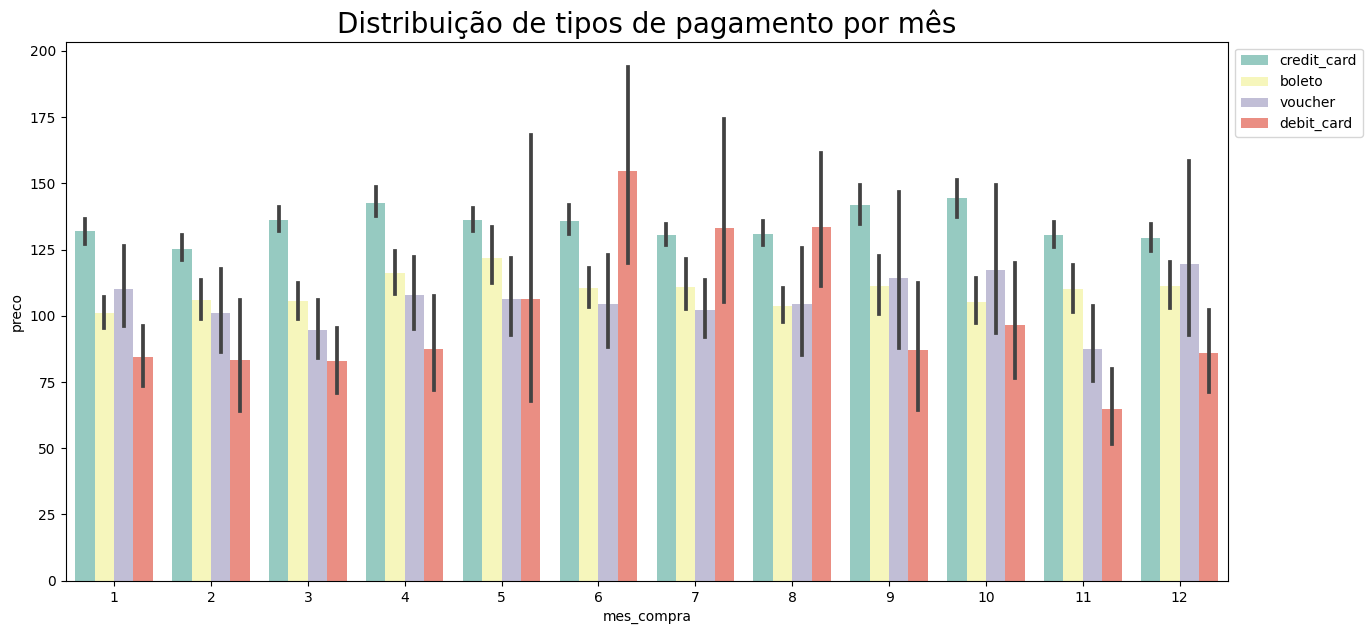

In [24]:
plt.figure(figsize = (15,7))

sns.barplot(x = 'mes_compra', y = 'preco', hue = 'tipo_pagamento', data = total_influencia_parcelas, palette = 'Set3')
g.set_xlabel('Ano', fontsize = 14)
g.set_ylabel('Quantidade de pedidos', fontsize = 14)
plt.title('Distribuição de tipos de pagamento por mês', fontsize = 20)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 2)

In [25]:
# Número de clientes X Receita

vendas_mesano = df_aux.groupby(['mes_compra', 'ano_compra']).agg({'preco':'sum',
                                                                  'id_cliente':'count'}).reset_index()
vendas_mesano

,mes_compra,ano_compra,preco,id_cliente
0,1,2017,120037.59,961
1,1,2018,961101.67,8364
2,2,2017,244342.30,1949
3,2,2018,860867.82,7765
4,3,2017,381305.59,3078
5,3,2018,994744.41,8337
6,4,2017,361157.69,2707
7,4,2018,1006279.64,8112
8,5,2017,528278.78,4260
9,5,2018,1012647.65,8104


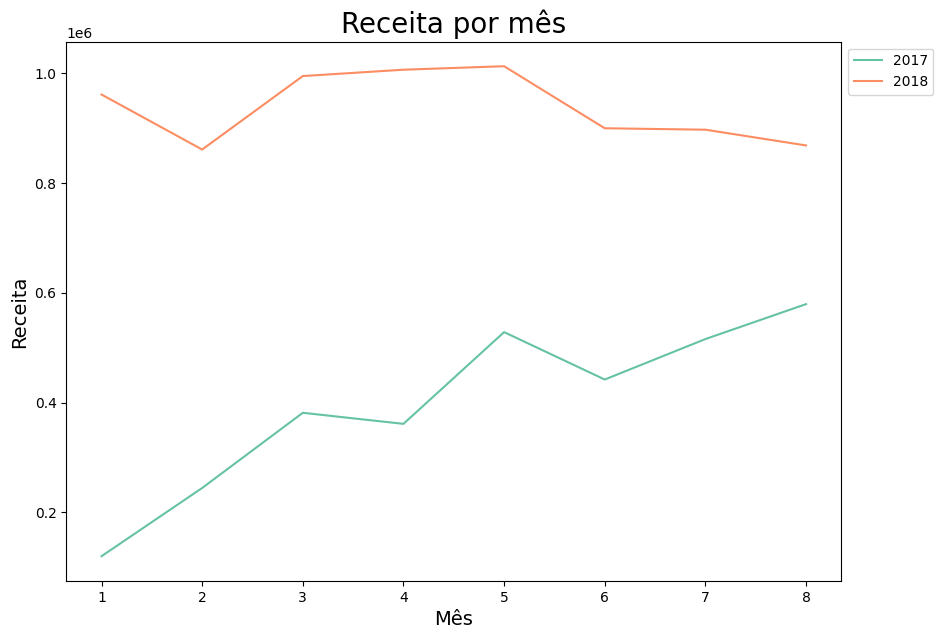

In [26]:
plt.figure(figsize=(10,7))
sns.lineplot(x="mes_compra", y="preco", hue='ano_compra',palette="Set2",
             data=vendas_mesano)
plt.title("Receita por mês", fontsize=20)
plt.xlabel("Mês",fontsize=14)
plt.ylabel("Receita",fontsize=14)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2);

O desvio padrão é  0.5163977794943222


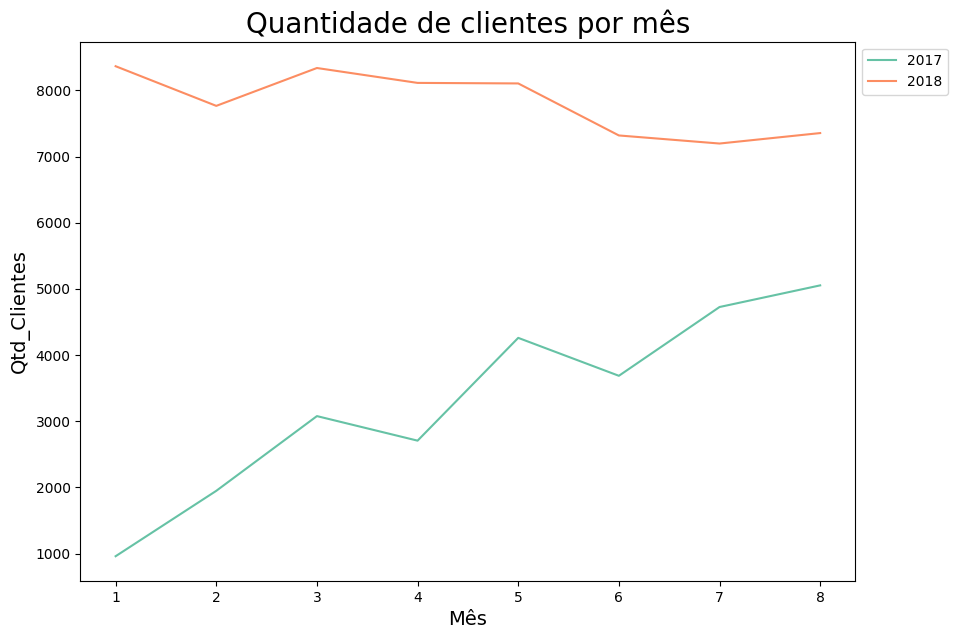

In [27]:
print('O desvio padrão é ', vendas_mesano['ano_compra'].std())
plt.figure(figsize=(10,7))
sns.lineplot(x="mes_compra", y="id_cliente", hue='ano_compra',palette="Set2",
             data=vendas_mesano)
plt.title('Quantidade de clientes por mês', fontsize = 20)
plt.xlabel('Mês', fontsize = 14)
plt.ylabel('Qtd_Clientes', fontsize = 14)
plt.legend(bbox_to_anchor=(1.0,1), loc = 2)

### Segmentação usando RFM

O termo RFM vem da junção de três siglas: Recência, Frequência e Monetaridade, buscando entender melhor o cliente e verificar quando foi sua última compra, quantas vezes comprou e quanto gastou com a empresa.

- Recência(R): Dias desde a última compra do cliente. 
- Frequência(F): Número de produtos comprados pelo cliente.
- Monetaridade(M): Total gasto em compras.

O modelo RFM é baseado no comportamento de compra do cliente, mas para isso é necessário definir um score.

Pontuação do cliente: A pontuação dos grupos do cliente varia de 1 a 5, onde quanto maior esse número, melhor. Essa pontuação é atribuída para cada sigla independentemente:

Quanto mais recente for a compra do cliente, maior será a pontuação de Recência (R). Quanto mais compras o cliente fizer, maior será a pontuação de Frequência (F). Quanto mais o cliente gastar em compras, maior será a pontuação que o cliente terá Monetaridade(M).

<div>
<center><img src="olist_rfm.png" width="800"/></center>
</div>

Para definir as pontuações dos clientes de 1 a 5, utilizou-se o algoritmo K-means, agrupando cada variável (RFM) por suas características semelhantes. Os clusters de R são ordenados pelos menores valores de recência e são pontuados em ordem decrescente. Os clusters F e M são ordenados pelos maiores valores e são pontuados em ordem decrescente, respeitando suas respectivas variáveis ​​(Frequência e Monetária).

In [28]:
max_date = max(df['data_compra']) + datetime.timedelta(days = 1)
max_date

datetime.date(2018, 8, 30)

In [29]:
recorrencia  = df.groupby(['customer_unique_id', 
                           'data_compra', 
                           'id_cliente', 
                           'preco'])['id_pedido'].nunique().sort_values(ascending=False).reset_index()
recorrencia = recorrencia.groupby(['customer_unique_id']).agg({'data_compra':lambda x:(max_date - x.max()).days,
                                   'id_cliente':'count',
                                   'preco':'sum'}).reset_index()

recorrencia.columns = ['id_cliente', 'recencia', 'frequencia', 'valor_gasto']
recorrencia.head()

,id_cliente,recencia,frequencia,valor_gasto
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,538,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,289,1,180.00


In [30]:
def get_segment(data):
    mean_fm = (data['F'] + data['M']) / 2
    
    if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 4 and mean_fm <= 5):
        return 'Champions'
    if (data['R'] >= 2 and data['R'] <= 5) and (mean_fm >= 3 and mean_fm <= 5):
        return 'Loyal Customers'
    if (data['R'] >= 3 and data['R'] <= 5) and (mean_fm >= 1 and mean_fm <= 3):
        return 'Potential Loyslist'
    if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 0 and mean_fm <= 1):
        return 'New Customers'
    if (data['R'] >= 3 and data['R'] <= 4) and (mean_fm >= 0 and mean_fm <= 1):
        return 'Promising'
    if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 2 and mean_fm <= 3):
        return 'Customer Needing Attention'
    if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 0 and mean_fm <= 2):
        return 'About to Sleep'
    if (data['R'] >= 0 and data['R'] <= 2) and (mean_fm >= 2 and mean_fm <= 5):
        return 'At Risk'
    if (data['R'] >= 0 and data['R'] <= 1) and (mean_fm >= 4 and mean_fm <= 5):
        return "Can't Lose Then"
    if (data['R'] >= 1 and data['R'] <= 2) and (mean_fm >= 1 and mean_fm <= 2):
        return 'Hibernating'
    return 'Lost'

In [31]:
recencia = recorrencia.iloc[:, 1].values
frequencia = recorrencia.iloc[:, 2].values
valor_gasto = recorrencia.iloc[:, 3].values
df_cluster = recorrencia[['id_cliente']]

In [32]:
def gerar_cluster(data, n_clusters, df, asc = False):
    data = data.reshape(-1, 1)
    scaler = StandardScaler()
    data_temp = scaler.fit_transform(data)
    kmeans_df = KMeans(n_clusters = n_clusters, random_state = 1)
    rotulos = kmeans_df.fit_predict(data)
    data_temp1 = np.column_stack((df, rotulos))
    data_temp1 = pd.DataFrame(data_temp1)
    
    return data_temp1

In [33]:
df_recencia = gerar_cluster(recencia, 5, df_cluster) 
df_recencia.columns = ['id_cliente', 'R']

df_frequencia = gerar_cluster(frequencia, 5, df_cluster)
df_frequencia.columns = ['id_cliente', 'F']

df_valor_gasto = gerar_cluster(valor_gasto, 5, df_cluster)
df_valor_gasto.columns = ['id_cliente', 'M']

In [34]:
data_cluster = pd.merge(df_cluster, df_recencia, on = 'id_cliente', how = 'left')
data_cluster = pd.merge(data_cluster, df_frequencia, on = 'id_cliente', how = 'left')
data_cluster = pd.merge(data_cluster, df_valor_gasto, on = 'id_cliente', how = 'left')
data_cluster = pd.merge(data_cluster, recorrencia, on = 'id_cliente', how = 'left')
data_cluster.sample(10)

,id_cliente,R,F,M,recencia,frequencia,valor_gasto
16760,2dd33269ef4cd004e2d2536fee365b56,1,0,0,187,1,125.00
15787,2b3ae868911dd0534cd71f4f30a02264,0,0,0,235,1,91.50
6559,11db7316e450c8fb9babbd97ff229cf0,3,0,0,85,1,44.80
61029,a712a430955027da5bc257a10073a390,3,0,0,2,1,149.90
32916,59f3535d39595a173769b7dc1b0e9b30,4,0,0,324,1,99.90
33608,5bcf87511a3d7b63b8b56fdb9ebe5fd5,0,2,2,311,3,197.25
52778,9101c89ca944110708708e96e8b2491a,0,0,0,261,1,65.99
90148,f71ada981403cb12be7003395a258a2f,1,0,0,104,1,13.77
66197,b5541d9a2ceb676fded2babc9bd9f9a7,0,0,0,308,1,30.00
67491,b8d50a7625e144be430dbc7d42d33d6d,4,0,0,321,1,59.90


Após verificar manualmente, vimos que a ordenação dos clusters estava errada, então classificamos manualmente até encontrarmos o erro

In [35]:
grupo = data_cluster.groupby('R')['recencia'].describe().reset_index()
grupo = grupo.sort_values(by = grupo.columns[0], ascending = True)
grupo

,R,count,mean,std,min,25%,50%,75%,max
0,0,22307.0,261.327700,31.130102,208.0,232.0,266.0,283.0,320.0
1,1,24302.0,153.562793,30.926691,102.0,126.0,154.0,181.0,207.0
2,2,11656.0,511.030199,49.055447,445.0,471.0,504.0,542.0,714.0
3,3,19863.0,49.042441,27.508212,1.0,25.0,45.0,73.0,101.0
4,4,15208.0,378.952262,35.025840,321.0,349.0,378.0,408.0,444.0


In [36]:
data_cluster['R']=data_cluster['R'].replace([4], 5)
data_cluster['R']=data_cluster['R'].replace([1], 4)
data_cluster['R']=data_cluster['R'].replace([2], 8)
data_cluster['R']=data_cluster['R'].replace([0], 2)
data_cluster['R']=data_cluster['R'].replace([3], 1)
data_cluster['R']=data_cluster['R'].replace([8], 3)
data_cluster['F']=data_cluster['F'].replace([3], 5)
data_cluster['F']=data_cluster['F'].replace([2], 3)
data_cluster['F']=data_cluster['F'].replace([1], 2)
data_cluster['F']=data_cluster['F'].replace([0], 1)
data_cluster['M']=data_cluster['M'].replace([2], 5)
data_cluster['M']=data_cluster['M'].replace([4], 2)
data_cluster['M']=data_cluster['M'].replace([3], 4)
data_cluster['M']=data_cluster['M'].replace([1], 3)
data_cluster['M']=data_cluster['M'].replace([0], 1)

In [37]:
data_cluster['segmento'] = data_cluster.apply(get_segment, axis = 1)

In [38]:
segmentwise = data_cluster.groupby('segmento').agg(RecencyMean = ('recencia', 'mean'),
                                                   FrequencyMean = ('frequencia', 'mean'),
                                                   MonetaryMean = ('valor_gasto', 'mean'),
                                                   GroupSize = ('recencia', 'size'))
segmentwise

,RecencyMean,FrequencyMean,MonetaryMean,GroupSize
segmento,,,,
About to Sleep,261.220653,1.030665,88.370995,17838
At Risk,49.612879,1.228493,310.532402,4022
Champions,221.584507,3.260563,268.600493,142
Customer Needing Attention,264.601594,1.685259,1108.984701,251
Hibernating,48.897607,1.030743,89.685509,15841
Loyal Customers,290.577647,1.123928,241.459756,13645
Potential Loyslist,301.909465,1.037527,107.336840,41597


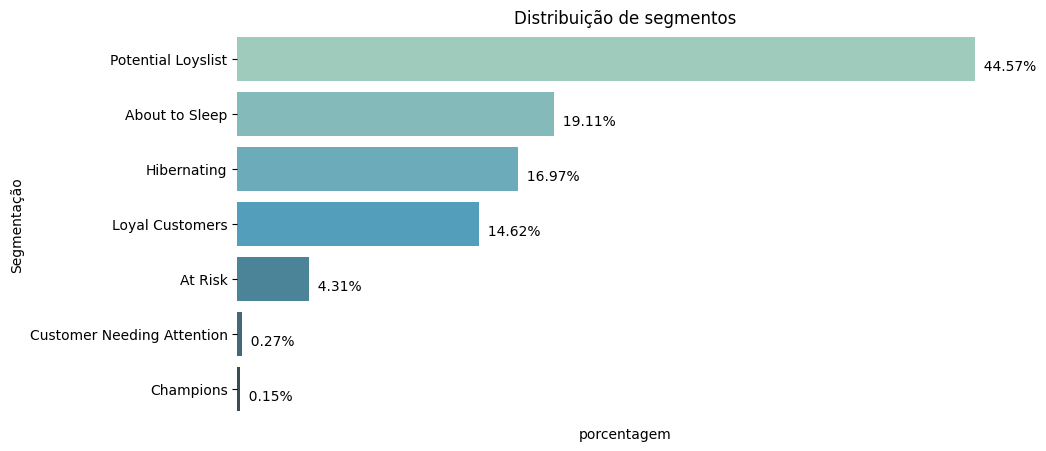

In [39]:
plt.figure(figsize=(10,5))
percentage = (data_cluster['segmento'].value_counts(normalize=True)* 100).reset_index(name='porcentagem')
g = sns.barplot(x=percentage['porcentagem'],y=percentage['index'], data=percentage,palette="GnBu_d")
sns.despine(bottom = True, left = True)
for i, v in enumerate(percentage['porcentagem']):
    g.text(v,i+0.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
g.set_ylabel('Segmentação')
g.set(xticks=[])
plt.title('Distribuição de segmentos')
plt.show()

## Conclusão

**44.57% - Potential Loyslist:**

Esse grupo é formado por compradores recentes, que possuem uma boa média de gasto e frequência. É um grupo com muito potencial, pois os clientes que tiveram uma experiência positiva recente com a empresa podem se interessar em fazer novas compras.

Estratégia CRM:

- Recomendações personalizadas de produtos. 
- Oferecer um programa de fidelidade ou vales de desconto.
- Mantenha esses clientes em potencial engajados com a marca.

**19.11 - About to Sleep:**

São clientes que, apesar de não comprarem há muito tempo, ainda podem comprar novamente. Esse grupo precisa de atenção, pois é o segundo segmento com mais clientes. É preciso reconquistar o interesse dessas pessoas pela empresa.

Estratégia CRM:

 - Recomendações e promoções de produtos populares
 - Comunicações personalizadas direcionadas ao perfil do cliente.

**16.97% - Hibernating:**

São clientes que compraram há muito tempo, apenas uma ou poucas vezes e gastaram pouco. Esse grupo precisa ser trabalhado para que a empresa volte a ser interessante para que seja leal.

Estratégia CRM:

- Ofertas de produtos relevantes e bons negócios.
- Comunicações de envio de ofertas.

**Loyal Customers:**

São clientes que gastam bem e com frequência. Esse grupo inclui clientes que já acreditam na empresa. É necessário manter esse relacionamento para que ele evolua para uma maior recência, e eles se tornem clientes Champions.

Estratégia CRM:

- Comunicação personalizada.
- Evite enviar ofertas genéricas em massa.
- Oferecer poucos produtos, mas apresentar produtos que possam interessar.
- Implemente alguma recompensa por avaliar produtos e avaliações para que eles estejam dispostos a expressar suas experiências positivas e motivar outros compradores.

**At Risk:**

São clientes que gastam pouco dinheiro e compram com frequência, mas não compram há muito tempo. Esse grupo mostra uma parcela de clientes que ao longo do tempo perdeu o interesse pela empresa. É preciso recuperar a atenção.

Estratégia CRM:

- Envio de comunicações e mensagens personalizadas para se aproximar do cliente.
- Ofereça bons negócios.

**Customers Needing Attention:**

São clientes que compraram recentemente, mas ainda podem ter dúvidas se farão sua próxima compra da empresa ou de um concorrente. Esse grupo precisa de ações para que percebam que a empresa pode oferecer as melhores condições e atender todas as suas expectativas. Algumas estratégias que podem ser interessantes

Estratégia CRM:

- Campanhas promocionais por tempo limitado, que criam a sensação de imperdível
- Mostre as vantagens que sua empresa oferece.
- Recomendações de produtos com base no seu comportamento.

**Champions:**

São clientes que compraram recentemente, compram com frequência e gastam muito. Verdadeiros vendedores indiretos da marca, e o objetivo principal deve ser aumentar cada vez mais esse grupo. Eles são defensores da marca. É necessário manter esse relacionamento para que o cliente permaneça engajado.

Estratégia CRM:

- Ofertas, produtos e descontos especiais para esses clientes para que se sintam valorizados.
- Evite enviar ofertas genéricas em massa.
- Comunicações personalizadas.
- Recompensas.
- Peça opiniões e feedbacks para mostrar que sua opinião como cliente é importante.


<center><img src = 'https://media.giphy.com/media/AeWoyE3ZT90YM/giphy.gif'></center>